In [1]:

import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/proj_energy_volatility


In [ ]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import het_arch

from arch import arch_model

from sklearn.linear_model import LinearRegression

from src.trading.IBKR_trading import TradingApp

In [3]:
plt.style.use("styler.mplstyle") 

## Feature Selection

In [129]:
def realized_vol(time_series, window: int = 21, annualize: bool = True) -> pd.DataFrame:
    """Compute rolling standard deviation of daily returns (realized volatility)."""
    
    volatility = time_series.rolling(window).std()
    
    if annualize:
        volatility *= np.sqrt(256)
    
    return volatility 

def long_to_wide(df, pivot_by='close'):

    wide = df.pivot(index='date', columns='Symbol', values=pivot_by)
    wide = wide.reset_index()  
    wide.columns.name = None

    return wide

In [5]:
HOST = os.getenv("IB_HOST")
PORT = int(os.getenv("IB_PORT"))
CLIENT_ID = int(os.getenv("IB_CLIENT_ID"))

app = TradingApp()
await app.start(HOST, PORT, clientid=CLIENT_ID)

Connected to Interactive Brokers successfully.


ERROR:ib_insync.wrapper:Error 321, reqId 9: Error validating request.-'bL' : cause - Historical data bar size setting is invalid. Legal ones are: 1 secs, 5 secs, 10 secs, 15 secs, 30 secs, 1 min, 2 mins, 3 mins, 5 mins, 10 mins, 15 mins, 20 mins, 30 mins, 1 hour, 2 hours, 3 hours, 4 hours, 8 hours, 1 day, 1W, 1M, contract: Stock(conId=4215217, symbol='XLE', exchange='SMART', primaryExchange='ARCA', currency='USD', localSymbol='XLE', tradingClass='XLE')
ERROR:ib_insync.wrapper:Error 321, reqId 10: Error validating request.-'bL' : cause - Historical data bar size setting is invalid. Legal ones are: 1 secs, 5 secs, 10 secs, 15 secs, 30 secs, 1 min, 2 mins, 3 mins, 5 mins, 10 mins, 15 mins, 20 mins, 30 mins, 1 hour, 2 hours, 3 hours, 4 hours, 8 hours, 1 day, 1W, 1M, contract: Stock(conId=756733, symbol='SPY', exchange='SMART', primaryExchange='ARCA', currency='USD', localSymbol='SPY', tradingClass='SPY')
ERROR:ib_insync.wrapper:Error 321, reqId 13: Error validating request.-'bL' : cause - 

In [6]:
macro = [
    'CPIAUCSL',   # CPI (All Urban Consumers)
    'INDPRO',     # Industrial Production Index
    'CNP16OV',    # Civilian Noninstitutional Population, 16+
    'FEDFUNDS',   # Effective Federal Funds Rate
    'VIXCLS',     # CBOE VIX Index (correct FRED ticker)
    'UNRATE'      # Unemployment Rate
]

In [8]:

fred = pdr.DataReader(
    macro,
    "fred",
    start="2015-07-01",
    end="2025-07-01"
).astype(float).reset_index()

# fred['INF'] = 400 * np.log(fred['CPIAUCSL']/ fred['CPIAUCSL'].shift(1))

fred = fred.fillna(method = 'ffill')

/tmp/ipykernel_13928/3150946655.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fred = fred.fillna(method = 'ffill')


In [9]:
fred

,DATE,CPIAUCSL,INDPRO,CNP16OV,FEDFUNDS,VIXCLS,UNRATE
0,2015-07-01,238.034,101.0893,250876.0,0.13,16.09,5.2
1,2015-07-02,238.034,101.0893,250876.0,0.13,16.79,5.2
2,2015-07-03,238.034,101.0893,250876.0,0.13,16.79,5.2
3,2015-07-06,238.034,101.0893,250876.0,0.13,17.01,5.2
4,2015-07-07,238.034,101.0893,250876.0,0.13,16.09,5.2
...,...,...,...,...,...,...,...
2639,2025-06-25,321.500,104.2115,273585.0,4.33,16.76,4.1
2640,2025-06-26,321.500,104.2115,273585.0,4.33,16.59,4.1
2641,2025-06-27,321.500,104.2115,273585.0,4.33,16.32,4.1
2642,2025-06-30,321.500,104.2115,273585.0,4.33,16.73,4.1


In [10]:
stock_data = [
    'XLE',
    'SPY',
    # Crude Oil 
    ]

In [92]:
index_stock = await app.fetch_many_symbols(stock_data, '10 Y', '1 day', 'TRADES', rth=True)
stock = long_to_wide(index_stock).sort_values(by=['date'])

In [93]:
stock

,date,SPY,XLE
0,2015-11-17,205.47,67.43
1,2015-11-18,208.73,68.54
2,2015-11-19,208.55,67.62
3,2015-11-20,209.31,66.90
4,2015-11-23,209.07,67.38
...,...,...,...
2508,2025-11-07,670.97,89.54
2509,2025-11-10,681.44,90.35
2510,2025-11-11,683.00,91.53
2511,2025-11-12,683.38,90.25


In [94]:
stock['XLE_r'] = np.log(stock['XLE'] / stock['XLE'].shift())
stock['SPY_r'] = np.log(stock['SPY'] / stock['SPY'].shift())

In [95]:
df = stock.merge(fred, left_on='date', right_on=['DATE']).drop(columns=['date'])

In [96]:
df.dropna(inplace=True)

#### Macro Features

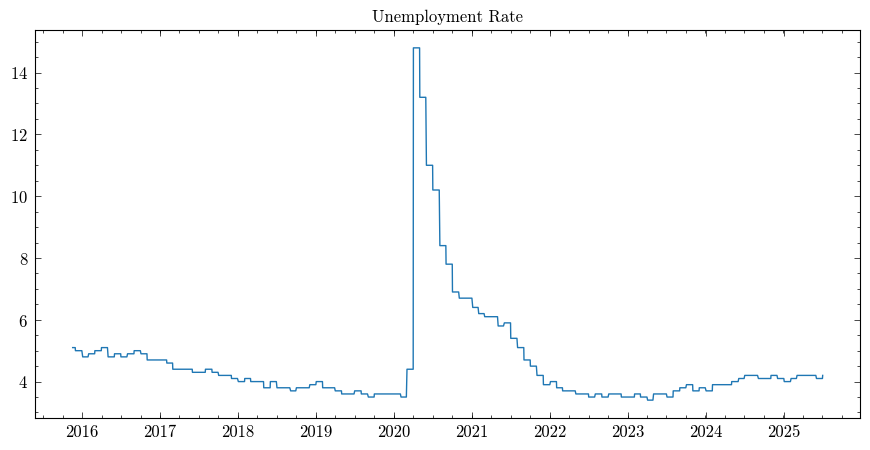

In [140]:
plt.figure(figsize=(10,5))
plt.title("Unemployment Rate")
plt.plot(df['DATE'], df['UNRATE'])

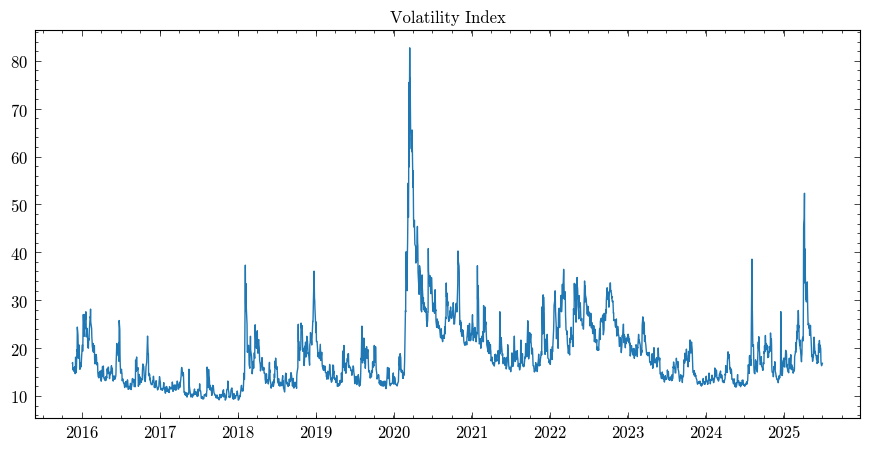

In [138]:
plt.figure(figsize=(10,5))
plt.title("Volatility Index")
plt.plot(df['DATE'], df['VIXCLS'])

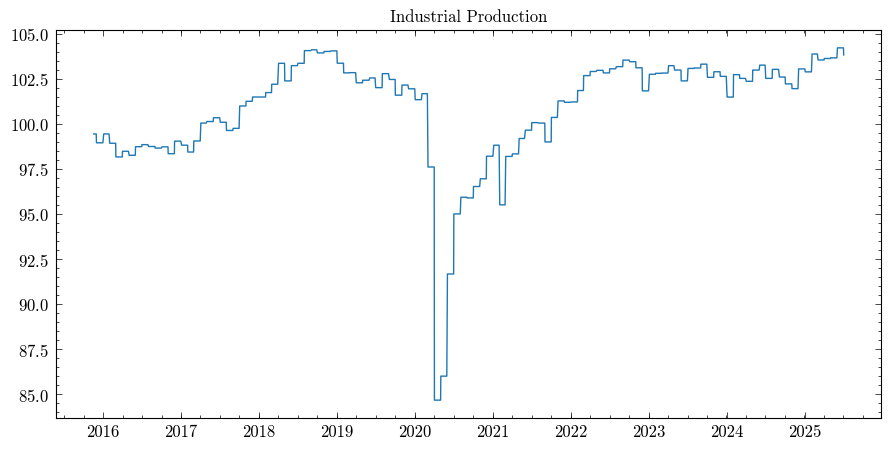

In [136]:
plt.figure(figsize=(10,5))
plt.title("Industrial Production")
plt.plot(df['DATE'], df['INDPRO'])

#### Stock and Indicators

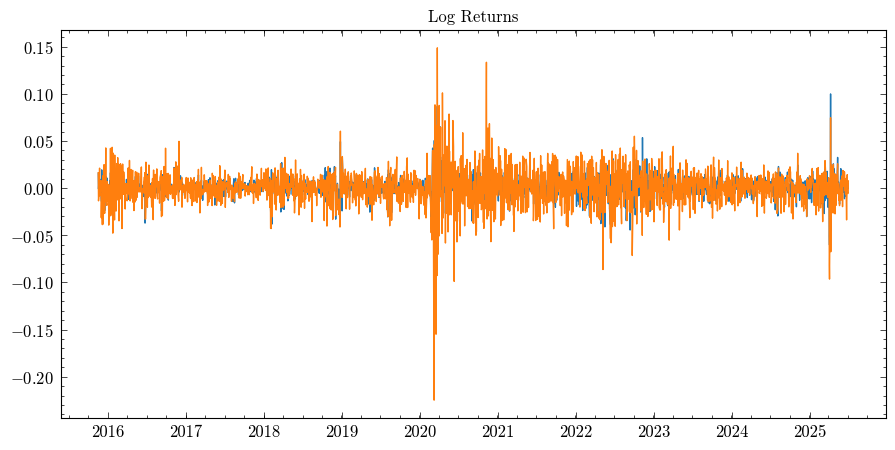

In [100]:
plt.figure(figsize=(10,5))
plt.title('Log Returns')
plt.plot(df['DATE'], df['SPY_r'])
plt.plot(df['DATE'], df['XLE_r'])

idiosyncratic volatility of XLE

In [130]:
X = df[['SPY_r']]   #
y = df['XLE_r']     

model = LinearRegression()
model.fit(X, y)


df['XLE_idio'] = y - model.predict(X)

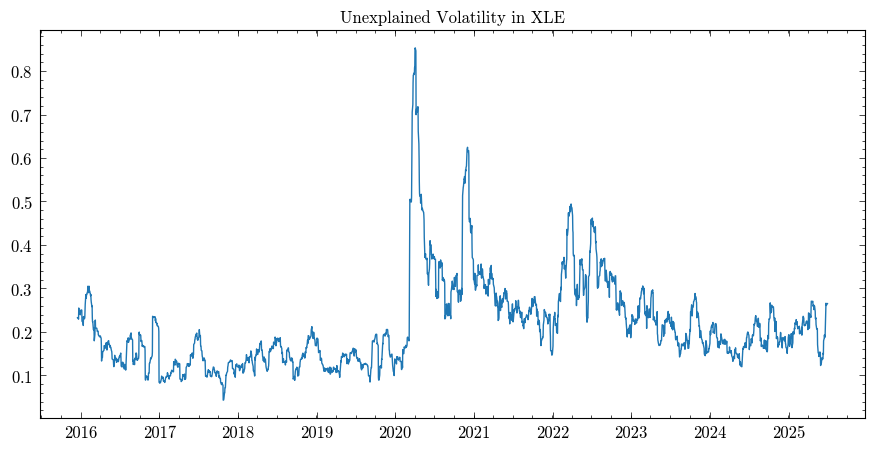

In [131]:
plt.figure(figsize=(10,5))
plt.title('Unexplained Volatility in XLE')
plt.plot(df['DATE'], realized_vol(df['XLE_idio']))

## GARCH

In [ ]:

stat, pval, fstat, fpval = het_arch(df['XLE_idio'].dropna())
print("ARCH p-value:", pval)

ARCH p-value: 5.57100375913047e-61


In [104]:
adfuller(df['XLE_r'])

(np.float64(-16.480890845175736),
 np.float64(2.2377366698496082e-29),
 6,
 2410,
 {'1%': np.float64(-3.4330662982661715),
  '5%': np.float64(-2.8627400264482548),
  '10%': np.float64(-2.5674088238838864)},
 np.float64(-12126.649704983623))

In [111]:
y  = df['XLE_r'] * 100
X = df[['CPIAUCSL', 'INDPRO', 'CNP16OV', 'FEDFUNDS', 'VIXCLS', 'UNRATE']]

In [112]:
y

1       1.632749
2      -1.351372
3      -1.070483
4       0.714927
5       2.114616
          ...   
2413   -0.436708
2414    1.421129
2415   -0.526163
2416   -0.576099
2417    0.763497
Name: XLE_r, Length: 2417, dtype: float64

In [122]:
am = arch_model(
    y,
    mean='ARX',       # mean with exogenous regressors
    lags=1,           # 0 AR lags in the mean (you can set >0 if you want AR)
    x=X,              # exogenous variables in the mean
    vol='GARCH',      # GARCH volatility
    p=1, q=2,         # GARCH(1,1)
    dist='t'     # or 't' if you want fat tails
)


In [123]:
res = am.fit(disp='off')

/tmp/ipykernel_13928/3265089574.py:1: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


In [124]:
cond_vol = res.conditional_volatility
std_resid = res.std_resid


In [125]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AR-X - GARCH Model Results                             
====================================================================================
Dep. Variable:                        XLE_r   R-squared:           -456299664242.827
Mean Model:                            AR-X   Adj. R-squared:      -457626116755.164
Vol Model:                            GARCH   Log-Likelihood:               -68639.2
Distribution:      Standardized Student's t   AIC:                           137304.
Method:                  Maximum Likelihood   BIC:                           137380.
                                              No. Observations:                 2416
Date:                      Thu, Nov 13 2025   Df Residuals:                     2408
Time:                              19:17:43   Df Model:                            8
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const        2330.0503  5.702e+04  4.086e-02      0.967  [-1.094e+05,1.141e+05]
XLE_r[1]    -8485.9821   1496.834     -5.669  1.434e-08 [-1.142e+04,-5.552e+03]
CPIAUCSL   -5.0786e+04     19.388  -2619.498      0.000 [-5.082e+04,-5.075e+04]
INDPRO     -3.4801e+04     30.979  -1123.390      0.000 [-3.486e+04,-3.474e+04]
CNP16OV        61.0710  8.344e-02    731.897      0.000       [ 60.907, 61.235]
FEDFUNDS   -1.7479e+04  1.274e+04     -1.372      0.170  [-4.246e+04,7.498e+03]
VIXCLS      4.0369e+04    392.952    102.732      0.000   [3.960e+04,4.114e+04]
UNRATE      3.5662e+04   9442.934      3.777  1.590e-04   [1.715e+04,5.417e+04]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega      3.5814e-08      4.773  7.504e-09      1.000 [ -9.354,  9.354]
alpha[1]       0.2790      0.472      0.591      0.555 [ -0.646,  1.204]
beta[1]        0.1753      0.901      0.194      0.846 [ -1.592,  1.942]
beta[2]        0.0000      2.013      0.000      1.000 [ -3.946,  3.946]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.1593  7.694e-04   2806.390      0.000 [  2.158,  2.161]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Iteration limit reached.
See convergence_flag.

"""

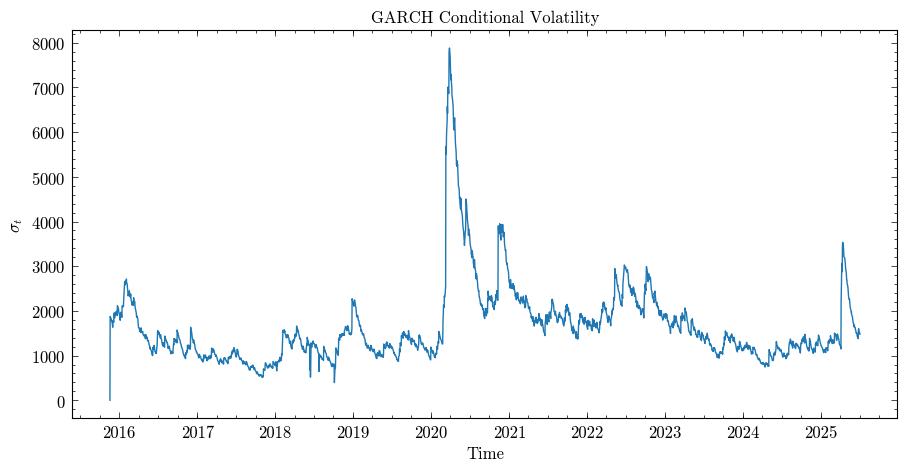

In [132]:

plt.figure(figsize=(10,5))
plt.plot(df['DATE'], res.conditional_volatility)
plt.title("GARCH Conditional Volatility")
plt.xlabel("Time")
plt.ylabel(r"$\sigma_t$")  
# plt.yscale('log')
plt.show()

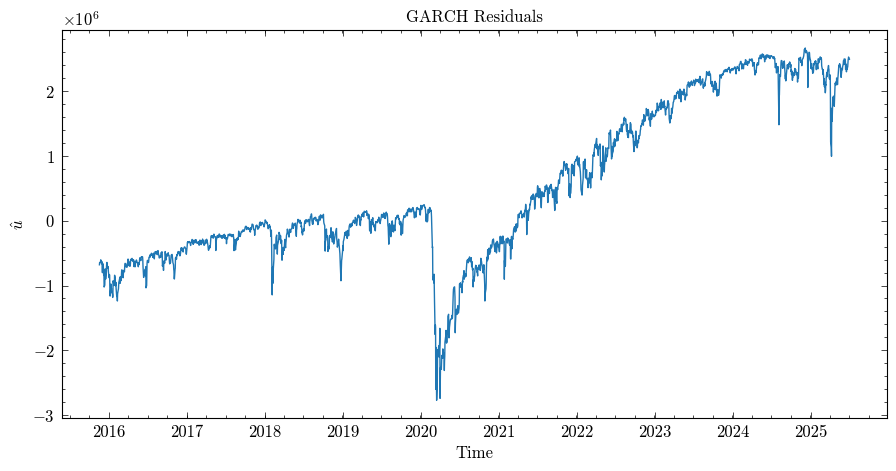

In [127]:

plt.figure(figsize=(10,5))
plt.plot(df['DATE'], res.resid)
plt.title("GARCH Residuals")
plt.xlabel("Time")
plt.ylabel("$\hat{u}$")
plt.show()

TO DO:


- Exogenous features need to be stationary 
- In-sample rolling prediction 
- Convert to scikit learn model
- hyperparameter tuning